<a href="https://colab.research.google.com/github/RamiKassouf/MachineLearning-ObjectDetectionAPI/blob/main/ModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ultralytics is an open-source deep learning library built on top of PyTorch. It provides a simple and efficient API for training and deploying state-of-the-art deep learning models for various tasks such as object detection, instance segmentation, and semantic segmentation. The library is developed and maintained by Ultralytics LLC, a computer vision and AI research company.

In [ ]:
pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 23.0 MB/s eta 0:00:00


In [ ]:
!git clone 'https://github.com/ultralytics/yolov5'  # clone

Cloning into 'yolov5'...
remote: Enumerating objects: 15639, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 15639 (delta 121), reused 142 (delta 69), pack-reused 15393
Receiving objects: 100% (15639/15639), 14.65 MiB | 29.59 MiB/s, done.
Resolving deltas: 100% (10649/10649), done.


In [ ]:
cd yolov5

/content/yolov5


In [ ]:
pip install -r requirements.txt  # install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#imports:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import json
import random
import shutil
import codecs


import torch
import utils


In [ ]:
display = utils.notebook_init()

YOLOv5 🚀 v7.0-156-g22a3cbb Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.5/78.2 GB disk)


In [ ]:
!unzip "/content/drive/MyDrive/sample_dataset.zip" -d "/content/drive/MyDrive/"

Archive:  /content/drive/MyDrive/sample_dataset.zip
  inflating: /content/drive/MyDrive/sample_dataset/.DS_Store  
  inflating: /content/drive/MyDrive/sample_dataset/objectclasses.json  
  inflating: /content/drive/MyDrive/sample_dataset/labels/.DS_Store  
  inflating: /content/drive/MyDrive/sample_dataset/labels/pascal/training_images_take_7_431.xml  
  inflating: /content/drive/MyDrive/sample_dataset/labels/pascal/training_images_take_7_379.xml  
  inflating: /content/drive/MyDrive/sample_dataset/labels/pascal/training_images_take_7_442.xml  
  inflating: /content/drive/MyDrive/sample_dataset/labels/pascal/training_images_take_7_415.xml  
  inflating: /content/drive/MyDrive/sample_dataset/labels/pascal/training_images_take_7_397.xml  
  inflating: /content/drive/MyDrive/sample_dataset/labels/pascal/training_images_take_7_388.xml  
  inflating: /content/drive/MyDrive/sample_dataset/labels/pascal/training_images_take_7_322.xml  
  inflating: /content/drive/MyDrive/sample_dataset/labels

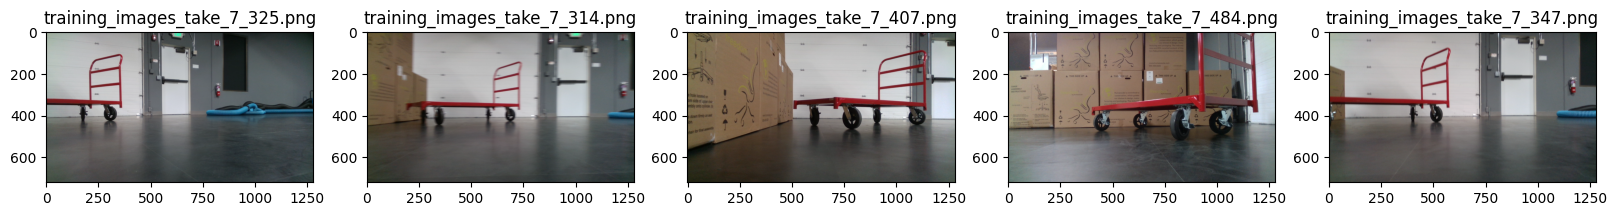

In [ ]:
import random
import cv2

#testing the access to the dataset by printing 5 random images
plt.figure(figsize=(20,20))
img_folder=r'/content/drive/MyDrive/sample_dataset/images'
IMG_WIDTH=200
IMG_HEIGHT=200
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img_rgb)

As for augmenting during the training, we would need to augment the images and the labels and there is little to no support for augmenting labels. Doing it manually is an option but it would require manually writing functions for every single transform we want to implement and remove the randomness of the transforms so that the label and the image get transform with the same values and that is not really feasible.

In [ ]:
# !python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source /content/drive/MyDrive/sample_dataset/images!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source /content/drive/MyDrive/sample_dataset/images

In [ ]:
def convert_labels_to_yolo(image_dir, label_dir, yolo_label_dir):
  #if the folder doesn't exist, create it
    if not os.path.exists(yolo_label_dir):
        os.mkdir(yolo_label_dir)
  #loop over all images
    for filename in os.listdir(image_dir):
      #if it's an image
        if filename.endswith(".jpg") or filename.endswith(".png"):
          #get path for image label and output
            image_path = os.path.join(image_dir, filename)
            label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".json")
            yolo_label_path = os.path.join(yolo_label_dir, os.path.splitext(filename)[0] + ".txt")
          #make sure that label name and image name are the same
            if os.path.exists(label_path):
              #read image
                image = cv2.imread(image_path)
              #get image dimensions
                image_height, image_width, _ = image.shape
              #load file
                with codecs.open(label_path, 'rb') as f:
                  print(label_path)
                  label_data = json.load(f)
              #create the output file
                with open(yolo_label_path, "w") as f:
                  #get data and write into file
                    for label in label_data:
                      #parse json
                        class_id = label["ObjectClassId"]
                        left = label["Left"]
                        top = label["Top"]
                        right = label["Right"]
                        bottom = label["Bottom"]
                      #transform to yolo format
                        x = (left + right) / 2 / image_width
                        y = (top + bottom) / 2 / image_height
                        w = (right - left) / image_width
                        h = (bottom - top) / image_height
                      #write yolo format
                        f.write(f"{class_id} {x} {y} {w} {h}\n")

In [ ]:
#transforming the labels into yolo_format
img_dir=r'/content/drive/MyDrive/sample_dataset/images'
label_dir=r'/content/drive/MyDrive/sample_dataset/labels/json'
labels_yolo_dir=r'/content/drive/MyDrive/sample_dataset/labels_yolo'

convert_labels_to_yolo(img_dir,label_dir,labels_yolo_dir)

/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_368.json
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_336.json
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_449.json
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_388.json
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_344.json
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_283.json
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_339.json
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_338.json
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_335.json
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_439.json
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_281.json
/content/drive/MyDrive/sample_dataset/labels/json/training_images_take_7_387.json
/content/drive/M

In [ ]:
# set the paths for images and labels directories
images_dir = img_dir
labels_dir = labels_yolo_dir

# set the percentages for train, test and validation sets
train_percent = 0.7
test_percent = 0.2
val_percent = 0.1

# create directories for train, test and validation sets

#if the folder doesn't exist, create it
main_dir='/content/datasets/dolly'

if not os.path.exists(main_dir):
    os.makedirs(main_dir)


os.makedirs(main_dir+'/train/images', exist_ok=True)
os.makedirs(main_dir+'/train/labels', exist_ok=True)
os.makedirs(main_dir+'/test/images', exist_ok=True)
os.makedirs(main_dir+'/test/labels', exist_ok=True)
os.makedirs(main_dir+'/val/images', exist_ok=True)
os.makedirs(main_dir+'/val/labels', exist_ok=True)

# get a list of all the image files
image_files = os.listdir(images_dir)

# shuffle the list
random.shuffle(image_files)

# calculate the number of files for each set
num_images = len(image_files)
num_train = int(num_images * train_percent)
num_test = int(num_images * test_percent)
num_val = int(num_images * val_percent)

# copy the image and label files into the appropriate directories
for i, image_file in enumerate(image_files):
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.png', '.txt'))
  #first num_train images go to train set
    if i < num_train:
        shutil.copy(image_path, main_dir+'/train/images')
        shutil.copy(label_path, main_dir+'/train/labels')
  #next num_test images go to test set
    elif i < num_train + num_test:
        shutil.copy(image_path, main_dir+'/test/images')
        shutil.copy(label_path, main_dir+'/test/labels')
  #the rest goes to val set
    else:
        shutil.copy(image_path, main_dir+'/val/images')
        shutil.copy(label_path, main_dir+'/val/labels')

In [ ]:
import yaml

data = {
    "train": "/content/datasets/dolly/train/images",
    "test": "/content/datasets/dolly/test/images",
    "val": "/content/datasets/dolly/val/images",
    "nc": 2,  # number of classes
    "names": [{0:"Dolly"}, {1:"Wheel"}],  # list of class names
    "img_size": [640, 640],  # image size used for training and inference
    "batch_size": 16,  # batch size used for training
    "epochs": 50,  # number of training epochs
    "hyp": {
        "giou": 0.05,
        "cls": 1.0,
        "cls_pw": 1.0,
        "obj": 1.0,
        "obj_pw": 1.0,
        "iou_t": 0.20,
        "lr": 0.001,
        "momentum": 0.937,
        "weight_decay": 0.0005,
        "fl_gamma": 0.0,
        "hsv_h": 0.015,
        "hsv_s": 0.7,
        "hsv_v": 0.4,
        "degrees": 0.0,
        "translate": 0.1,
        "scale": 0.5,
        "shear": 0.0,
        "perspective": 0.0,
        "flipud": 0.0,
        "fliplr": 0.5,
        "mosaic": 1.0,
    },
}
main_dir=r'/content/datasets'
with open(main_dir+"/dolly.yaml", "w") as f:
    yaml.dump(data, f)

In [ ]:
!python train.py --img 640 --batch-size 16 --epochs 50 --data /content/datasets/dolly.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/datasets/dolly.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-156-g22a3cbb Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_p

**Note:**

mAP50 and mAP5095 are evaluation metrics commonly used in object detection tasks to measure the performance of the model.

mAP50 (mean average precision at 50%) is a metric that calculates the average precision at different levels of recall, where the maximum level of recall is 50%. This metric is useful when the aim is to evaluate the performance of the model on detecting objects accurately, especially for tasks where high precision is necessary, such as detecting rare or dangerous objects.

On the other hand, mAP5095 (mean average precision at 50% and 95%) is a more comprehensive metric that considers the average precision at two levels of recall, 50% and 95%. This metric is useful when the aim is to evaluate the performance of the model on detecting both common and rare objects accurately.

Both mAP50 and mAP5095 are important metrics in object detection because they provide a quantitative measure of the model's accuracy in detecting objects, which can help in comparing different models and selecting the best one for a given task. Moreover, these metrics can also help in identifying the strengths and weaknesses of the model and guide improvements in the model architecture and training process.

In [ ]:
!python val.py --weights runs/train/exp5/weights/best.pt --data /content/datasets/dolly.yaml --img 640 --augment

val: data=/content/datasets/dolly.yaml, weights=['runs/train/exp5/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-156-g22a3cbb Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/datasets/dolly/val/labels.cache... 37 images, 0 backgrounds, 0 corrupt: 100% 37/37 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:02<00:00,  1.42s/it]
                   all         37        170      0.986      0.992       0.99      0.792
          {0: 'Dolly'}         37         37       

In [ ]:
# Function to show validation predictions saved during training.
import glob
def show_valid_results(RES_DIR):
    !ls {RES_DIR}
    EXP_PATH = f"{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

confusion_matrix.png  PR_curve.png	     val_batch0_pred.jpg
F1_curve.png	      R_curve.png	     val_batch1_labels.jpg
P_curve.png	      val_batch0_labels.jpg  val_batch1_pred.jpg
['runs/val/exp2/val_batch0_pred.jpg', 'runs/val/exp2/val_batch1_pred.jpg']


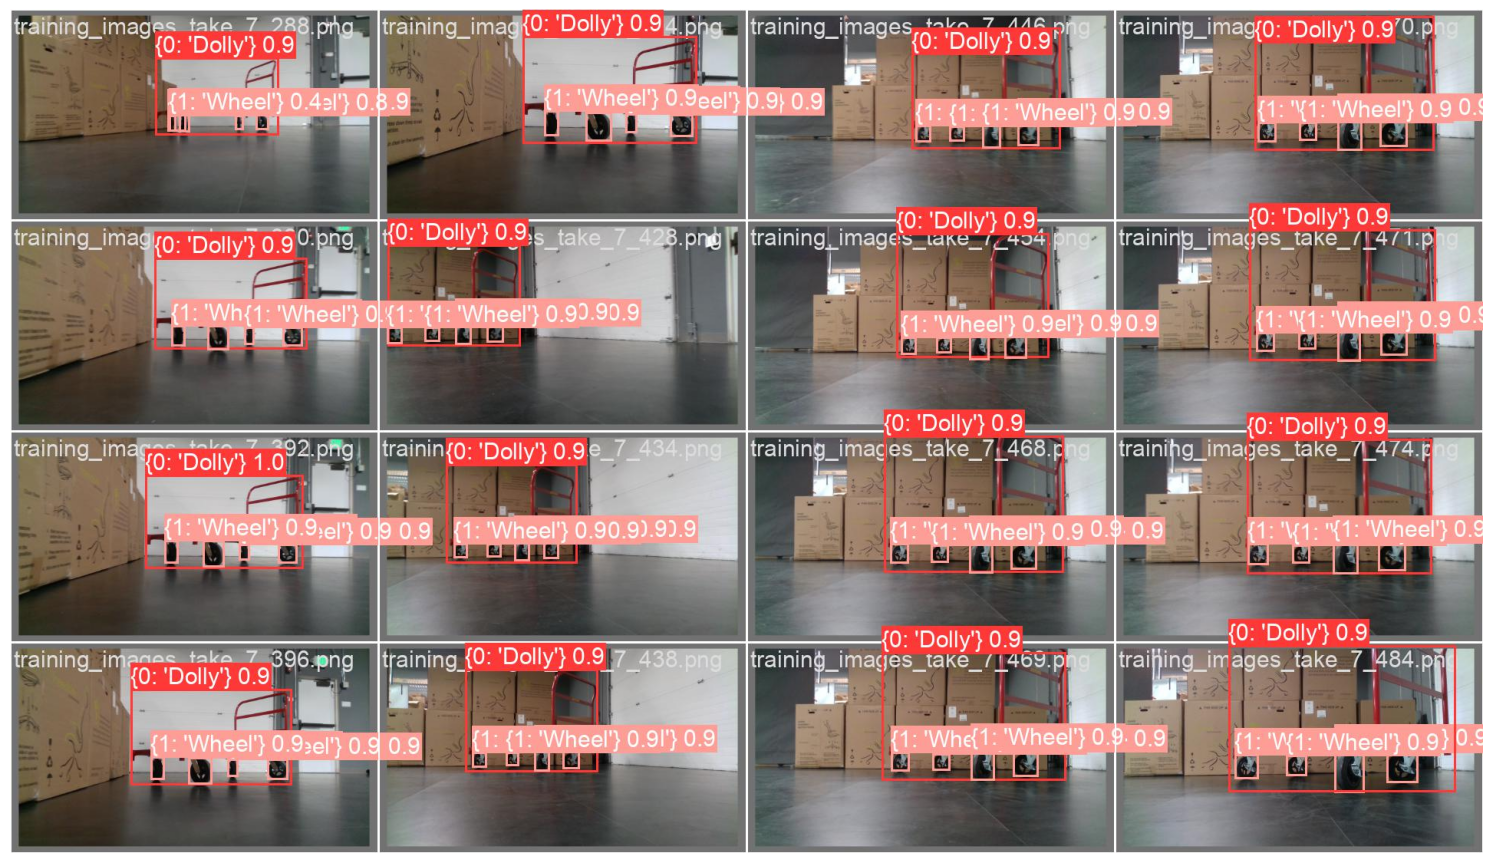

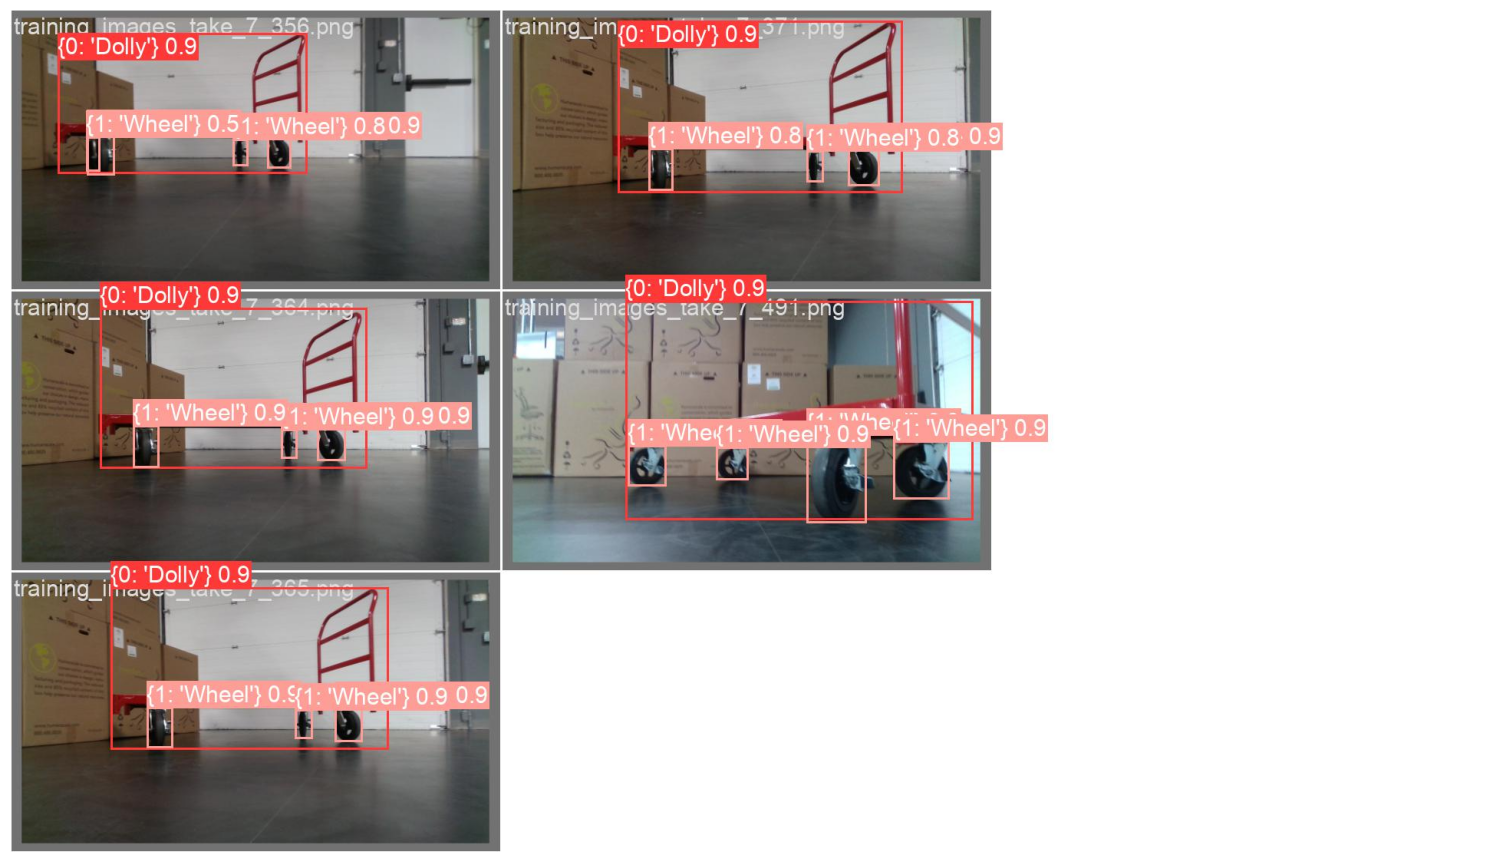

In [ ]:
show_valid_results('runs/val/exp2')

In [ ]:
!python detect.py --weights runs/train/exp5/weights/best.pt --data /content/datasets/dolly.yaml --source /content/datasets/dolly/test/images --img 640 --augment

detect: weights=['runs/train/exp5/weights/best.pt'], source=/content/datasets/dolly/test/images, data=/content/datasets/dolly.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-156-g22a3cbb Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/71 /content/datasets/dolly/test/images/training_images_take_7_279.png: 384x640 1 {0: 'Dolly'}, 5 {1: 'Wheel'}s, 145.3ms
image 2/71 /content/datasets/dolly/test/images/training_images_take_7_280.png: 384x640 1 {0: 'Dolly'}, 5 {1: 'Wheel'}s, 21.8ms

ONNX (Open Neural Network Exchange) is an open-source file format that allows for the interchange of deep learning models between different frameworks.

In [ ]:
!python export.py --weights runs/train/exp5/weights/best.pt --include onnx

export: data=data/coco128.yaml, weights=['runs/train/exp5/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-156-g22a3cbb Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from runs/train/exp5/weights/best.pt with output shape (1, 25200, 7) (13.7 MB)

ONNX: starting export with onnx 1.13.1...
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: export success ✅ 1.7s, saved as runs/train/exp5/weights/best.onnx (27.2 MB)

Export complete (3.3s)
Results saved to /conte

In [ ]:
!pip install netron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.3 MB/s eta 0:00:00


In [ ]:
#check exported model name
!netron /content/yolov5/yolov5/runs/train/exp/weights/best.onnx

Model file '/content/yolov5/yolov5/runs/train/exp/weights/best.onnx' does not exist.


For hyperparmeter tuning we tried a different optimizer which is the Adam optimizer to see its impact on the model and the evaluation metrics.

In [ ]:
!python train.py --img 640 --batch-size 16 --epochs 70 --data /content/datasets/dolly.yaml --weights yolov5s.pt --cache --optimizer Adam

train: weights=yolov5s.pt, cfg=, data=/content/datasets/dolly.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=70, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-156-g22a3cbb Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_

Step 7 : Fatser R-CNN

Note: For the Faster RCNN model we could've used the same way in yolo and use the cmd line, but we wanted to apply a different approach

In [ ]:
!pip install torch-snippets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import PIL
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch_snippets import Report
import os
import time
import xml.etree.ElementTree as ET

In [ ]:
def xml_to_dict(xml_path):
    # Decode the .xml file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    # Return the image size, object label and bounding box
    # coordinates together with the filename as a dict.
    return {"filename": xml_path,
            "image_width": int(root.find("./size/width").text),
            "image_height": int(root.find("./size/height").text),
            "image_channels": int(root.find("./size/depth").text),
            "label": root.find("./object/name").text,
            "x1": int(root.find("./object/bndbox/xmin").text),
            "y1": int(root.find("./object/bndbox/ymin").text),
            "x2": int(root.find("./object/bndbox/xmax").text),
            "y2": int(root.find("./object/bndbox/ymax").text)}

In [ ]:
# Convert human readable str label to int.
label_dict = {"Dolly": 1, "Wheel" : 2}
# Convert label int to human readable str.
reverse_label_dict = {2: "Wheel", 1: "Dolly"}

class DollyDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms = None):
        """
        Inputs
            root: str
                Path to the data folder.
            transforms: Compose or list
                Torchvision image transformations.
        """
        self.root = root
        self.transforms = transforms
        self.files = sorted(os.listdir(os.path.join(self.root,"images/")))
        for i in range(len(self.files)):
            self.files[i] = self.files[i].split(".")[0]
            self.label_dict = label_dict
    def __getitem__(self, i):
        # Load image
        if(self.files[i]!=""):
            img = PIL.Image.open(os.path.join(self.root,
                  "images/" + self.files[i] + ".png")).convert("RGB")
            # Load annotation file

            ann_path = os.path.join(self.root, "labels/pascal/" + self.files[i] + ".xml")
            if os.path.exists(ann_path):
              ann = xml_to_dict(ann_path)
              # The target is given as a dict.
              target = {}
              target["boxes"] = torch.as_tensor([[ann["x1"],
                                                  ann["y1"],
                                                  ann["x2"],
                                                  ann["y2"]]],
                                        dtype = torch.float32)
              target["labels"]=torch.as_tensor([label_dict[ann["label"]]],
                              dtype = torch.int64)
              target["image_id"] = torch.as_tensor(i)
            # else:
            #   # Create a default target dictionary
            #   target = {}
            #   target["boxes"] = torch.zeros((1, 4), dtype=torch.float32)
            #   target["labels"] = torch.zeros(1, dtype=torch.int64)
            #   target["image_id"] = torch.as_tensor(i)

            # Apply any transforms to the data if required.
              if self.transforms is not None:
                  img, target = self.transforms(img, target)
              return img, target
    def __len__(self):
        return len(self.files)

In [ ]:
import torchvision.transforms.functional as F
import torchvision.transforms.transforms as T
class Compose:
    """
    Composes several torchvision image transforms
    as a sequence of transformations.
    Inputs
        transforms: list
            List of torchvision image transformations.
    Returns
        image: tensor
        target: dict
    """
    def __init__(self, transforms = []):
        self.transforms = transforms
    # __call__ sequentially performs the image transformations on
    # the input image, and returns the augmented image.
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [ ]:
class ToTensor(torch.nn.Module):
    """
    Converts a PIL image into a torch tensor.
    Inputs
        image: PIL Image
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image, target
class RandomHorizontalFlip(T.RandomHorizontalFlip):
    """
    Randomly flips an image horizontally.
    Inputs
        image: tensor
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                width, _ = F.get_image_size(image)
                target["boxes"][:, [0, 2]] = width - \
                                     target["boxes"][:, [2, 0]]
        return image, target

In [ ]:
def get_transform(train):
    """
    Transforms a PIL Image into a torch tensor, and performs
    random horizontal flipping of the image if training a model.
    Inputs
        train: bool
            Flag indicating whether model training will occur.
    Returns
        compose: Compose
            Composition of image transforms.
    """
    transforms = []
    # ToTensor is applied to all images.
    transforms.append(ToTensor())
    # The following transforms are applied only to the train set.
    if train == True:
        transforms.append(RandomHorizontalFlip(0.5))
        # Other transforms can be added here later on.
    return Compose(transforms)

In [ ]:
# images_dir = r'/content/drive/MyDrive/sample_dataset/images'
# labels_dir = r'/content/drive/MyDrive/sample_dataset/labels/pascal'

# # set the percentages for train, test and validation sets
# train_percent = 0.7
# test_percent = 0.2
# val_percent = 0.1

# # create directories for train, test and validation sets

# #if the folder doesn't exist, create it
# main_dir='/content/datasets/dolly_rcnn'

# if not os.path.exists(main_dir):
#     os.makedirs(main_dir)


# os.makedirs(main_dir+'/train/images', exist_ok=True)
# os.makedirs(main_dir+'/train/labels', exist_ok=True)
# os.makedirs(main_dir+'/test/images', exist_ok=True)
# os.makedirs(main_dir+'/test/labels', exist_ok=True)
# os.makedirs(main_dir+'/val/images', exist_ok=True)
# os.makedirs(main_dir+'/val/labels', exist_ok=True)

# # get a list of all the image files
# image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]

# # shuffle the list
# random.shuffle(image_files)

# # calculate the number of files for each set
# num_images = len(image_files)
# num_train = int(num_images * train_percent)
# num_test = int(num_images * test_percent)
# num_val = int(num_images * val_percent)

# # copy the image and label files into the appropriate directories
# for i, image_file in enumerate(image_files):
#     image_path = os.path.join(images_dir, image_file)
#     label_path = os.path.join(labels_dir, image_file.replace('.png', '.xml'))
#   #first num_train images go to train set
#     if i < num_train:
#         shutil.copy(image_path, main_dir+'/train/images')
#         shutil.copy(label_path, main_dir+'/train/labels')
#   #next num_test images go to test set
#     elif i < num_train + num_test:
#         shutil.copy(image_path, main_dir+'/test/images')
#         shutil.copy(label_path, main_dir+'/test/labels')
#   #the rest goes to val set
#     else:
#         shutil.copy(image_path, main_dir+'/val/images')
#         shutil.copy(label_path, main_dir+'/val/labels')

In [ ]:
# Train dataset.
# Set train = True to apply the training image transforms.
train_ds = DollyDataset("/content/drive/MyDrive/sample_dataset", get_transform(train = True))
# Validation dataset.
val_ds = DollyDataset("/content/drive/MyDrive/sample_dataset", get_transform(train = False))
# Test dataset.
test_ds = DollyDataset("/content/drive/MyDrive/sample_dataset", get_transform(train = False))

In [ ]:
# Randomly shuffle all the data.
indices = torch.randperm(len(train_ds)).tolist()
# We split the entire data into 80/20 train-test splits. We further
# split the train set into 80/20 train-validation splits.
# Train dataset: 64% of the entire data, or 80% of 80%.
train_ds = torch.utils.data.Subset(train_ds,
           indices[:int(len(indices) * 0.64)])
# Validation dataset: 16% of the entire data, or 20% of 80%.
val_ds = torch.utils.data.Subset(val_ds,
         indices[int(len(indices) * 0.64):int(len(indices) * 0.8)])
# Test dataset: 20% of the entire data.
test_ds = torch.utils.data.Subset(test_ds,
          indices[int(len(indices) * 0.8):])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
# Create the DataLoaders from the Datasets.
train_dl = torch.utils.data.DataLoader(train_ds,
                                 batch_size = 4,
                                 shuffle = True,
                        collate_fn = collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds,
                             batch_size = 4,
                            shuffle = False,
                    collate_fn = collate_fn)
test_dl = torch.utils.data.DataLoader(test_ds,
                               batch_size = 4,
                              shuffle = False,
                      collate_fn = collate_fn)

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_object_detection_model(num_classes = 3,
                               feature_extraction = True):
    """
    Inputs
        num_classes: int
            Number of classes to predict. Must include the
            background which is class 0 by definition!
        feature_extraction: bool
            Flag indicating whether to freeze the pre-trained
            weights. If set to True the pre-trained weights will be
            frozen and not be updated during.
    Returns
        model: FasterRCNN
    """
    # Load the pretrained faster r-cnn model.
    model = fasterrcnn_resnet50_fpn(pretrained = True)
    # If True, the pre-trained weights will be frozen.
    if feature_extraction == True:
        for p in model.parameters():
            p.requires_grad = False
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats,
                                                   num_classes)
    return model

In [ ]:
def unbatch(batch, device):
    """
    Unbatches a batch of data from the Dataloader.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        X: list
            List of images.
        y: list
            List of dictionaries.
    """
    X, y = batch
    X = [x.to(device) for x in X]
    y = [{k: v.to(device) for k, v in t.items()} for t in y]
    return X, y
def train_batch(batch, model, optimizer, device):
    """
    Uses back propagation to train a model.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses
@torch.no_grad()
def validate_batch(batch, model, optimizer, device):
    """
    Evaluates a model's loss value using validation data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [ ]:
def train_fasterrcnn(model,
                 optimizer,
                  n_epochs,
              train_loader,
        test_loader = None,
                log = None,
               keys = None,
            device = "cpu"):
    """
    Trains a FasterRCNN model using train and validation
    Dataloaders over n_epochs.
    Returns a Report on the training and validation losses.
    Inputs
        model: FasterRCNN
        optimizer: torch optimizer
        n_epochs: int
            Number of epochs to train.
        train_loader: DataLoader
        test_loader: DataLoader
        log: Record
            torch_snippet Record to record training progress.
        keys: list
            List of strs containing the FasterRCNN loss names.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        log: Record
            torch_snippet Record containing the training records.
    """
    if log is None:
        log = Report(n_epochs)
    if keys is None:
        # FasterRCNN loss names.
        keys = ["loss_classifier",
                   "loss_box_reg",
                "loss_objectness",
               "loss_rpn_box_reg"]
    model.to(device)
    for epoch in range(n_epochs):
        N = len(train_loader)
        for ix, batch in enumerate(train_loader):
            loss, losses = train_batch(batch, model,
                                  optimizer, device)
            # Record the current train loss.
            pos = epoch + (ix + 1) / N
            log.record(pos = pos, trn_loss = loss.item(),
                       end = "\r")
        if test_loader is not None:
            N = len(test_loader)
            for ix, batch in enumerate(test_loader):
                loss, losses = validate_batch(batch, model,
                                         optimizer, device)

                # Record the current validation loss.
                pos = epoch + (ix + 1) / N
                log.record(pos = pos, val_loss = loss.item(),
                           end = "\r")
    log.report_avgs(epoch + 1)
    return log

In [ ]:
# Create the faster rcnn model with 3 classes - dolly, wheel and
# background.
model = get_object_detection_model(num_classes = 3,
                        feature_extraction = False)
# Use the stochastic gradient descent optimizer.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                        lr = 0.005,
                    momentum = 0.9,
             weight_decay = 0.0005)
# Train the model over 10 epoch.
log = train_fasterrcnn(model = model,
               optimizer = optimizer,
                        n_epochs = 10,
             train_loader = train_dl,
                test_loader = val_dl,
             log = None, keys = None,
                     device = torch.device("cuda"))

EPOCH: 10.000  trn_loss: 0.082  val_loss: 0.141  (487.09s - 0.00s remaining)


In [ ]:
torch.save(model.state_dict(), "/content/model_weights10.pt")

More transformation, and epochs.

In [ ]:
class ColorJitter(T.ColorJitter):
    """
    Randomly adjust brightness, contrast, and saturation of an image.
    Inputs
        image: tensor
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target=None):
        image = super(ColorJitter, self).forward(image)
        return image, target


class RandomCrop(T.RandomCrop):
    """
    Randomly crop an image.
    Inputs
        image: tensor
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target=None):
        i, j, h, w = self.get_params(image, self.size)
        image = F.crop(image, i, j, h, w)
        if target is not None:
            target["boxes"][:, [0, 2]] -= j
            target["boxes"][:, [1, 3]] -= i
        return image, target


class Grayscale(T.Grayscale):
    """
    Convert image to grayscale.
    Inputs
        image: tensor
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target=None):
        image = super(Grayscale, self).forward(image)
        return image, target


def get_transform2(train):
    """
    Transforms a PIL Image into a torch tensor, and performs
    random horizontal flipping, random crop, grayscale, and color jitter if training a model.
    Inputs
        train: bool
            Flag indicating whether model training will occur.
    Returns
        compose: Compose
            Composition of image transforms.
    """
    transforms = []
    # ToTensor is applied to all images.
    transforms.append(ToTensor())
    # The following transforms are applied only to the train set.
    if train == True:
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1))
        transforms.append(RandomCrop(224))
    # Grayscale is applied to all images.
    transforms.append(Grayscale(num_output_channels=3))
    return T.Compose(transforms)

In [ ]:
model50 = get_object_detection_model(num_classes = 3,
                        feature_extraction = False)
# Use the stochastic gradient descent optimizer.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                        lr = 0.005,
                    momentum = 0.9,
             weight_decay = 0.0005)
# Train the model over 1 epoch.
log50 = train_fasterrcnn(model = model50,
               optimizer = optimizer,
                        n_epochs = 50,
             train_loader = train_dl,
                test_loader = val_dl,

             log = None, keys = None,
                     device = torch.device("cuda"))

EPOCH: 50.000  trn_loss: 1.539  val_loss: 1.557  (2391.36s - 0.00s remaining)


In [ ]:
torch.save(model50.state_dict(), "/content/model_weights50.pt")

In [ ]:
@torch.no_grad()
def predict_batch(batch, model, device):
    """
    Gets the predictions for a batch of data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the
            bounding boxes, labels and confidence scores.
    """
    model.to(device)
    model.eval()
    X, _ = unbatch(batch, device = device)
    predictions = model(X)
    return [x.cpu() for x in X], predictions
def predict(model, data_loader, device = "cpu"):
    """
    Gets the predictions for a batch of data.
    Inputs
        model: torch model
        data_loader: torch Dataloader
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the
            bounding boxes, labels and confidence scores.
    """
    images = []
    predictions = []
    for i, batch in enumerate(data_loader):
        X, p = predict_batch(batch, model, device)
        images = images + X
        predictions = predictions + p

    return images, predictions

In [ ]:
def decode_prediction(prediction,
                      score_threshold = 0.8,
                      nms_iou_threshold = 0.2):
    """
    Inputs
        prediction: dict
        score_threshold: float
        nms_iou_threshold: float
    Returns
        prediction: tuple
    """
    boxes = prediction["boxes"]
    scores = prediction["scores"]
    labels = prediction["labels"]
    # Remove any low-score predictions.
    if score_threshold is not None:
        want = scores > score_threshold
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    # Remove any overlapping bounding boxes using NMS.
    if nms_iou_threshold is not None:
        want = torchvision.ops.nms(boxes = boxes, scores = scores,
                                iou_threshold = nms_iou_threshold)
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    return (boxes.cpu().numpy(),
            labels.cpu().numpy(),
            scores.cpu().numpy())

In [ ]:
model5 = get_object_detection_model(num_classes = 3,
                        feature_extraction = False)
# Use the stochastic gradient descent optimizer.
params = [p for p in model5.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                        lr = 0.005,
                    momentum = 0.9,
             weight_decay = 0.0005)
# Train the model over 1 epoch.
log5 = train_fasterrcnn(model = model5,
               optimizer = optimizer,
                        n_epochs = 5,
             train_loader = train_dl,
                test_loader = val_dl,

             log = None, keys = None,
                     device = torch.device("cuda"))

EPOCH: 5.000  trn_loss: 0.112  val_loss: 0.134  (242.26s - 0.00s remaining)


In [ ]:
torch.save(model5.state_dict(), "/content/model_weights5.pt")

In [ ]:
images, predictions = predict(model5, val_dl, torch.device("cuda"))

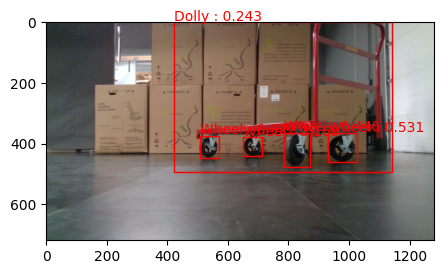

In [ ]:
#visualization
img_index = 1
boxes, labels, scores = decode_prediction(predictions[img_index],0)
fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]],
            scores[i]), color = "r")
plt.show()

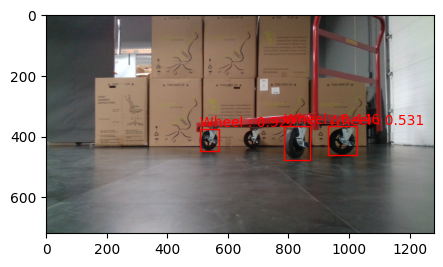

In [ ]:
#visualization

img_index = 1
boxes, labels, scores = decode_prediction(predictions[img_index],0.4)
fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]],
            scores[i]), color = "r")
plt.show()

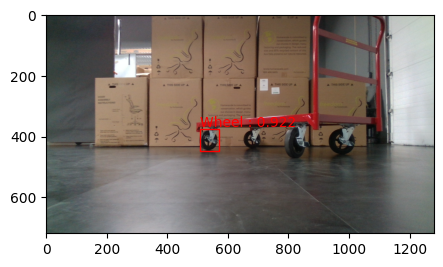

In [ ]:
#visualization
img_index = 1
boxes, labels, scores = decode_prediction(predictions[img_index],0.7)
fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]],
            scores[i]), color = "r")
plt.show()

prediction using model trained on 200 epochs.

In [ ]:
images, predictions = predict(model50, val_dl, torch.device("cuda"))

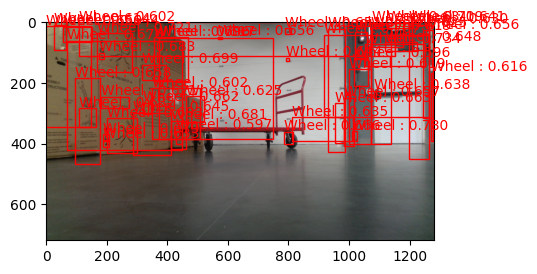

In [ ]:
#visualization
img_index = 5
boxes, labels, scores = decode_prediction(predictions[img_index],0)
fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]],
            scores[i]), color = "r")
plt.show()

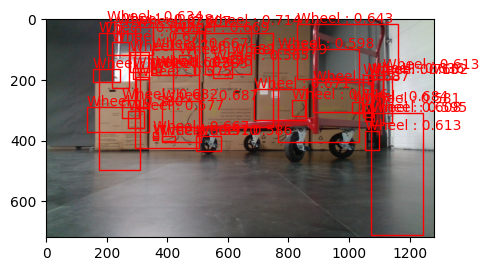

In [ ]:
#visualization

img_index = 1
boxes, labels, scores = decode_prediction(predictions[img_index],0.4)
fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]],
            scores[i]), color = "r")
plt.show()

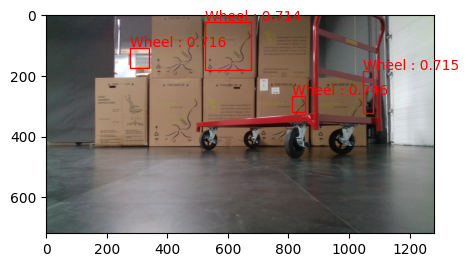

In [ ]:
#visualization
img_index = 1
boxes, labels, scores = decode_prediction(predictions[img_index],0.7)
fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]],
            scores[i]), color = "r")
plt.show()

train on different optimizer and parameters.

In [ ]:
import gc
del model50
gc.collect()

40348

In [ ]:
#we choose Adam as optimizer this time

modelAdam = get_object_detection_model(num_classes = 3,
                        feature_extraction = False)
# Use the stochastic gradient descent optimizer.
params = [p for p in modelAdam.parameters() if p.requires_grad]

optimizer2 = torch.optim.Adam(params,
                             lr=0.001,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)

logAdam = train_fasterrcnn(model = modelAdam,
               optimizer = optimizer2,
                        n_epochs = 50,
             train_loader = train_dl,
                test_loader = val_dl,
             log = None, keys = None,
                     device = torch.device("cuda"))

EPOCH: 50.000  trn_loss: 0.697  val_loss: 0.684  (2329.43s - 0.00s remaining)


In [ ]:
torch.save(modelAdam.state_dict(), "/content/model_weightsAdam.pt")

In [ ]:
modelAdam2 = get_object_detection_model(num_classes = 3,
                        feature_extraction = False)
# Use the stochastic gradient descent optimizer.
params = [p for p in modelAdam2.parameters() if p.requires_grad]

optimizer2 = torch.optim.Adam(params,
                             lr=0.001,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)

logAdam = train_fasterrcnn(model = modelAdam2,
               optimizer = optimizer2,
                        n_epochs = 5,
             train_loader = train_dl,
                test_loader = val_dl,
             log = None, keys = None,
                     device = torch.device("cuda"))

EPOCH: 5.000  trn_loss: 0.178  val_loss: 0.188  (241.63s - 0.00s remaining)


In [ ]:
torch.save(modelAdam2.state_dict(), "/content/model_weights50.pt")

In [ ]:
images, predictions = predict(modelAdam2, val_dl, torch.device("cuda"))

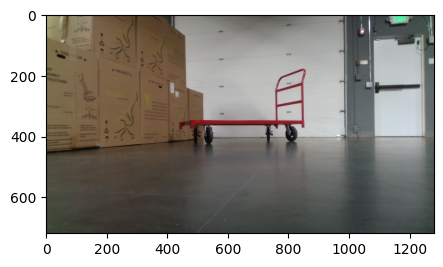

In [ ]:
#visualization
img_index = 5
boxes, labels, scores = decode_prediction(predictions[img_index])
fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]],
            scores[i]), color = "r")
plt.show()

We displayed multiple versions of the image depending on the value of the threshold and how the shown bboxes will be affected by the value of iou.

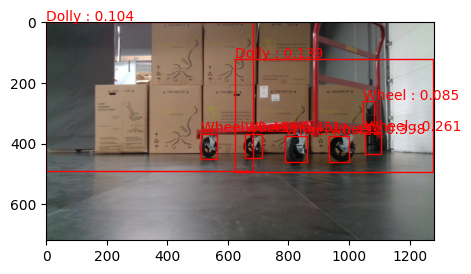

In [ ]:
#visualization
img_index = 1
boxes, labels, scores = decode_prediction(predictions[img_index],0)
fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]],
            scores[i]), color = "r")
plt.show()

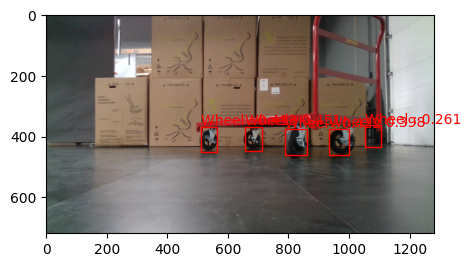

In [ ]:
#visualization

img_index = 1
boxes, labels, scores = decode_prediction(predictions[img_index],0.2)
fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]],
            scores[i]), color = "r")
plt.show()

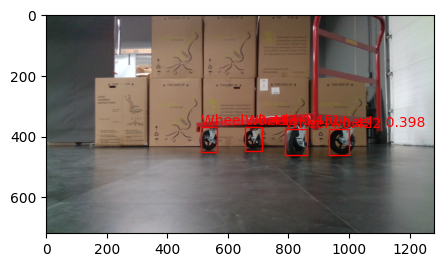

In [ ]:
#visualization
img_index = 1
boxes, labels, scores = decode_prediction(predictions[img_index],0.3)
fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]],
            scores[i]), color = "r")
plt.show()

In [ ]:
# import onnx
# checkpoint_path = '/content/model_weights.pt'
# new_model = get_object_detection_model(num_classes = 3,
#                         feature_extraction = False)
# new_model.load_state_dict(torch.load(checkpoint_path))
# model = torch.load(checkpoint_path)

In [ ]:

# new_model.eval()

In [ ]:
# import torch
# import torchvision.transforms as transforms
# import PIL.Image

# # # Define an example input
# # example_input = torch.randn(1, 3, 224, 224)

# # # Convert the model to ONNX format
# # input_names = ["input"]
# # output_names = ["output"]
# # onnx_path = "path/to/model.onnx"
# # torch.onnx.export(model, example_input, onnx_path, input_names=input_names, output_names=output_names)

# # # Verify that the model can be loaded from the ONNX file
# # loaded_model = onnx.load(onnx_path)
# # onnx.checker.check_model(loaded_model)

# output_onnx = '/content/faster_rcnn_dolly.onnx'
# print("==> Exporting model to ONNX format at '{}'".format(output_onnx))
# input_names = ["input0"]
# output_names = ["output0"]
# img = PIL.Image.open("/content/drive/MyDrive/sample_dataset/images/training_images_take_7_280.png").convert("RGB")
# transform = transforms.Compose([
#     transforms.Resize((640, 640)),
#     transforms.ToTensor(),
# ])

# # Apply the transformation to the image
# tensor = transform(img)


# # Add an extra dimension to the tensor to represent the batch size
# tensor = tensor.unsqueeze(0)
# # tensor=tensor.to(torch.device('cuda'))

# torch_out = torch.onnx._export(new_model, tensor, output_onnx, export_params=True, verbose=False)

In [ ]:
# # # Verify that the model can be loaded from the ONNX file
# loaded_model = onnx.load('/content/faster_rcnn_dolly.onnx')
# onnx.checker.check_model(loaded_model)

Comparison between faster rcnn and yolov5:
Faster R-CNN is a two-stage object detection model that uses a region proposal network (RPN) to generate region proposals, followed by a Fast R-CNN network to classify the proposals and refine their bounding boxes. It achieves high accuracy on object detection but is relatively slower than other models.

On the other hand, YOLOv5 is a one-stage object detection model that uses a single convolutional neural network to predict the class probabilities and bounding boxes directly. It is faster than Faster R-CNN and has a high accuracy rate, especially in detecting small objects.

In terms of speed, YOLOv5 is faster than Faster R-CNN even in inference.In terms of accuracy, Faster R-CNN outperforms YOLOv5 in terms of mean average precision (mAP).